# **Accredian** **Task**

## Fraudulent Data Analysis and Prediction


---



Note: Due to limited RAM on the local machine and Colab VM, the workflow uses an out-of-core pattern: the raw CSV is read in chunks, features are engineered per chunk, and results are written to Parquet shards so that only a single chunk is in memory at any time. This approach follows pandas’ guidance for scaling to datasets larger than memory via chunking and columnar formats.

**Step1: Importing libraries**

---



In [1]:
# =====Imports and setup =====
import os, gc, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
print("Libraries imported successfully")

Libraries imported successfully


**Step 2: Mouted dataset "Fraud.csv" from drive**

---



This config block defines a memory-safe ingestion setup for a large fraud dataset in Colab by specifying input/output paths, constraining per-chunk size, tightening dtypes, and capping rows used for training to fit within available RAM. It sets up chunked CSV reading with selected columns, writes processed data to fast columnar Parquet, and limits training data volume to maintain stability.

In [2]:
# =====Config =====
INPUT_CSV = '/content/drive/MyDrive/Fraud.csv'  #Drive path
OUT_DIR = '/content/fraud_parquet'
os.makedirs(OUT_DIR, exist_ok=True)

CHUNKSIZE = 500_000         # tune chunk size to available RAM
USECOLS = [
    'step','type','amount','nameOrig','oldbalanceOrg','newbalanceOrig',
    'nameDest','oldbalanceDest','newbalanceDest','isFraud'
]
DTYPES = {
    'step':'int32','amount':'float32','oldbalanceOrg':'float32','newbalanceOrig':'float32',
    'oldbalanceDest':'float32','newbalanceDest':'float32','isFraud':'int8'
}
CATEGORICAL_TYPES = {'type':'category'}

SAMPLE_ROWS_FOR_TRAIN = 2_000_000   # cap rows loaded for model training to fit RAM
PARQUET_ENGINE = 'pyarrow'          # fast columnar reads

print("Starting memory-safe pipeline")

Starting memory-safe pipeline


### **Feature Engineering**

---



Memory usage is reduced by loading only required columns via usecols, enforcing compact dtypes (int32/float32/int8), and dropping heavy string columns after extracting lightweight indicators. These practices minimize the DataFrame footprint during ingestion and transformation.


Instead of full dataset processing in one go, it builds a Parquet-backed dataset and then loads a bounded sample for EDA/modeling to keep peak memory stable. Columnar Parquet files enable faster, selective reads for iterative development.

In [3]:
# ===== Chunked feature engineering to Parquet shards =====
def fe_on_chunk(df):
    # Cast dtypes early
    for col, dt in DTYPES.items():
        if col in df.columns:
            df[col] = df[col].astype(dt)
    for col, cat in CATEGORICAL_TYPES.items():
        if col in df.columns:
            df[col] = df[col].astype(cat)

    # Minimal features (keep memory cost low)
    if 'type' in df.columns:
        type_map = {'CASH_OUT':0,'PAYMENT':1,'CASH_IN':2,'TRANSFER':3,'DEBIT':4}
        df['type_encoded'] = df['type'].map(type_map)
        # Explicitly add -1 as a category before filling NA
        if -1 not in df['type_encoded'].cat.categories:
             df['type_encoded'] = df['type_encoded'].cat.add_categories([-1])
        df['type_encoded'] = df['type_encoded'].fillna(-1).astype('int8')


    if {'oldbalanceOrg','newbalanceOrig'} <= set(df.columns):
        df['balance_change_orig'] = (df['newbalanceOrig'] - df['oldbalanceOrg']).astype('float32')
        df['orig_balance_zero_flag'] = (df['oldbalanceOrg'] == 0).astype('int8')

    if {'oldbalanceDest','newbalanceDest'} <= set(df.columns):
        df['balance_change_dest'] = (df['newbalanceDest'] - df['oldbalanceDest']).astype('float32')
        df['dest_balance_zero_flag'] = (df['oldbalanceDest'] == 0).astype('int8')

    if 'amount' in df.columns:
        df['amount_log'] = np.log1p(df['amount']).astype('float32')
        if 'oldbalanceOrg' in df.columns:
            denom = (df['oldbalanceOrg'] > 0)
            df['amount_to_orig_ratio'] = np.where(denom, df['amount']/df['oldbalanceOrg'], 0).astype('float32')

    if 'step' in df.columns:
        df['hour'] = (df['step'] % 24).astype('int8')
        df['day'] = (df['step'] // 24).astype('int32')
        df['is_weekend'] = ((df['day'] % 7) >= 5).astype('int8')
        df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype('int8')

    # Encode name prefixes only; avoid keeping full long strings
    if 'nameOrig' in df.columns:
        df['orig_is_merchant'] = (df['nameOrig'].str.startswith('M')).astype('int8')
    if 'nameDest' in df.columns:
        df['dest_is_merchant'] = (df['nameDest'].str.startswith('M')).astype('int8')


    # Remove heavy string columns to save RAM before writing
    drop_cols = [c for c in ['nameOrig','nameDest','type'] if c in df.columns]
    df.drop(columns=drop_cols, inplace=True)

    # Optional: simple outlier capping on critical numerics (IQR per chunk)
    for col in ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
                'balance_change_orig','balance_change_dest','amount_to_orig_ratio']:
        if col in df.columns:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = (q3 - q1)
            if pd.notna(iqr) and iqr > 0:
                low = q1 - 1.5*iqr
                high = q3 + 1.5*iqr
                df[col] = df[col].clip(low, high).astype('float32')

    return df

print("Streaming CSV -> FE -> Parquet shards ...")
shard_idx = 0
row_count = 0
for chunk in pd.read_csv(
    INPUT_CSV,
    usecols=USECOLS,
    dtype={k:v for k,v in DTYPES.items() if k in USECOLS},
    chunksize=CHUNKSIZE,
    low_memory=False
):
    chunk = fe_on_chunk(chunk)
    shard_path = os.path.join(OUT_DIR, f'shard_{shard_idx:04d}.parquet')
    chunk.to_parquet(shard_path, index=False, engine=PARQUET_ENGINE)
    row_count += len(chunk)
    shard_idx += 1
    del chunk
    gc.collect()
    print(f"  • Wrote {shard_path} (total rows so far: {row_count:,})")

print(f"Wrote {shard_idx} shards to {OUT_DIR} (rows: {row_count:,})")

Streaming CSV -> FE -> Parquet shards ...
  • Wrote /content/fraud_parquet/shard_0000.parquet (total rows so far: 500,000)
  • Wrote /content/fraud_parquet/shard_0001.parquet (total rows so far: 1,000,000)
  • Wrote /content/fraud_parquet/shard_0002.parquet (total rows so far: 1,500,000)
  • Wrote /content/fraud_parquet/shard_0003.parquet (total rows so far: 2,000,000)
  • Wrote /content/fraud_parquet/shard_0004.parquet (total rows so far: 2,500,000)
  • Wrote /content/fraud_parquet/shard_0005.parquet (total rows so far: 3,000,000)
  • Wrote /content/fraud_parquet/shard_0006.parquet (total rows so far: 3,500,000)
  • Wrote /content/fraud_parquet/shard_0007.parquet (total rows so far: 4,000,000)
  • Wrote /content/fraud_parquet/shard_0008.parquet (total rows so far: 4,500,000)
  • Wrote /content/fraud_parquet/shard_0009.parquet (total rows so far: 5,000,000)
  • Wrote /content/fraud_parquet/shard_0010.parquet (total rows so far: 5,500,000)
  • Wrote /content/fraud_parquet/shard_0011.par

### **Exploratory Data Analysis**

---



This snippet iterates over Parquet shards, sampling just enough rows from each file to reach a predefined cap, then concatenates those samples into a single DataFrame for EDA and model training to keep memory usage bounded. It avoids loading the full dataset at once by incrementally sampling per shard, freeing intermediates with garbage collection, and stopping once the target sample size is met.

In [4]:
# Load a bounded sample for EDA and training =====
print("Loading bounded sample for training/EDA...")
# Reservoir sample from shards to cap memory
rng = np.random.default_rng(42)
samples = []
remaining = SAMPLE_ROWS_FOR_TRAIN
for fname in sorted(os.listdir(OUT_DIR)):
    if not fname.endswith('.parquet'):
        continue
    path = os.path.join(OUT_DIR, fname)
    df_shard = pd.read_parquet(path, engine=PARQUET_ENGINE)
    take = min(remaining, len(df_shard))
    if take > 0:
        frac = take / len(df_shard)
        samp = df_shard.sample(frac=frac, random_state=42) if frac < 1 else df_shard
        samples.append(samp)
        remaining -= len(samp)
    del df_shard
    gc.collect()
    if remaining <= 0:
        break

df = pd.concat(samples, ignore_index=True) if samples else pd.DataFrame()
del samples
gc.collect()
print(f"Sampled dataset shape: {df.shape}")


Loading bounded sample for training/EDA...
Sampled dataset shape: (2000000, 20)


This section prints a quick dataset overview by showing the first three rows and a truncated descriptive summary to validate schema and basic statistics without overwhelming memory or output. It limits correlation analysis to up to 15 numeric features and visualizes their correlation heatmap, reducing computation and ensuring the multicollinearity check stays lightweight.

Overview
   step       amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1  9839.639648       170136.0   160296.359375             0.0   
1     1  1864.280029        21249.0    19384.720703             0.0   
2     1   181.000000          181.0        0.000000             0.0   

   newbalanceDest  isFraud  type_encoded  balance_change_orig  \
0             0.0        0             1         -9839.640625   
1             0.0        0             1         -1864.279297   
2             0.0        1             3          -181.000000   

   orig_balance_zero_flag  balance_change_dest  dest_balance_zero_flag  \
0                       0                  0.0                       1   
1                       0                  0.0                       1   
2                       0                  0.0                       1   

   amount_log  amount_to_orig_ratio  hour  day  is_weekend  is_night  \
0    9.194276              0.057834     1    0           0         1   
1   

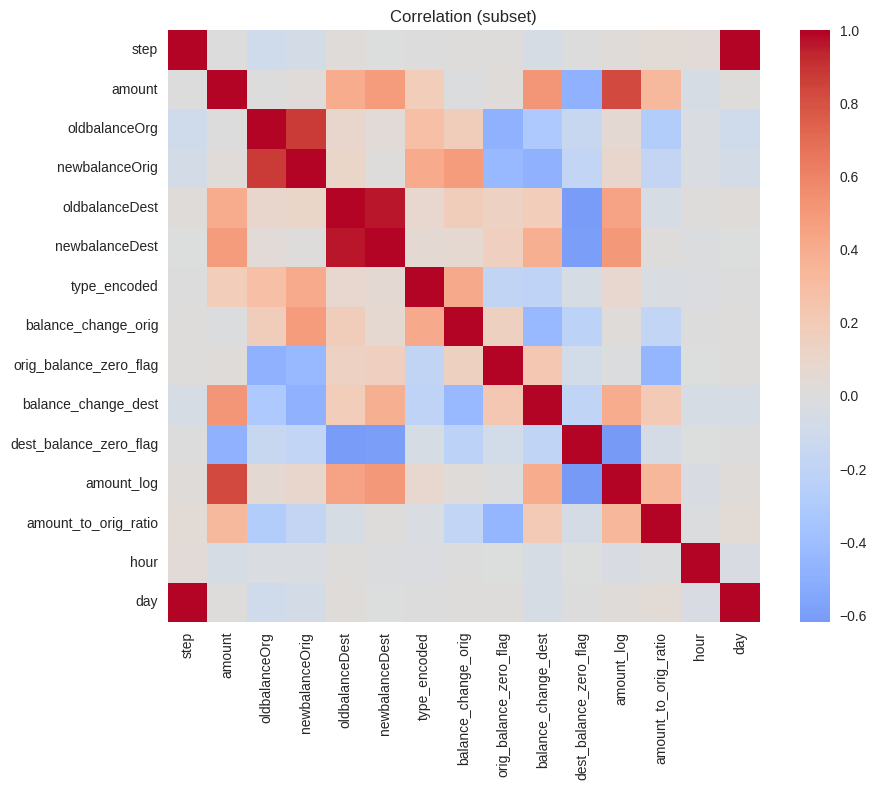

In [5]:

print("Overview")
if not df.empty:
    print(df.head(3))
    print(df.describe(include='all').T.head(20))

# =====Multicollinearity (subset to numeric and limit columns) =====
print("Correlation on numeric subset")
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'isFraud']
corr_cols = num_cols[:15]  # cap for heatmap
if len(corr_cols) >= 2:
    corr = df[corr_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation (subset)')
    plt.tight_layout()
    plt.show()

### **Feature Selection**

---



This block performs a fast, memory-light feature selection by computing mutual information scores on numeric predictors only, then picking the top-k features to form X_selected for modeling. By avoiding recursive/wrapper methods and using compact dtypes, it keeps computation efficient and stable under RAM limits while retaining the most informative signals for fraud prediction.

In [6]:
# =====Feature selection (lightweight) =====
print("Lightweight feature selection")
target_col = 'isFraud'
feature_cols = [c for c in df.columns if c != target_col]

# Use simple univariate ranking (mutual_info or correlation proxy) to avoid RFE
from sklearn.feature_selection import mutual_info_classif
X_fs = df[feature_cols].select_dtypes(include=[np.number]).fillna(0)
feature_cols = list(X_fs.columns)
y = df[target_col].astype('int8')

mi = mutual_info_classif(X_fs, y, random_state=42, discrete_features='auto')
mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)
top_k = 15
selected_features = mi_series.head(min(top_k, len(mi_series))).index.tolist()
X_selected = X_fs[selected_features].astype('float32')
print("Selected features:", selected_features)

Lightweight feature selection
Selected features: ['type_encoded', 'is_weekend', 'dest_balance_zero_flag', 'dest_is_merchant', 'orig_balance_zero_flag', 'day', 'hour', 'amount_to_orig_ratio', 'balance_change_orig', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'is_night', 'oldbalanceDest', 'newbalanceDest']


### **Training the model**

---



*Trained two models:*


Logistic Regression: Trains on standardized features with class_weight='balanced' to handle class imbalance, offering a fast, low-memory baseline; probabilities are used to compute AUC and Average Precision for evaluation.

Random Forest: Fits a shallow, regularized ensemble (100 trees, max_depth=8, min_samples_split=20, min_samples_leaf=10, balanced_subsample) to control RAM and overfitting, then evaluates via predicted probabilities for AUC and Average Precision.

In [ ]:

print("Training models (memory-safe)")
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

models = {
    'LogReg': LogisticRegression(
        max_iter=1000, class_weight='balanced', C=0.5, n_jobs=1
    ),
    'RF_shallow': RandomForestClassifier(
        n_estimators=100, max_depth=8, min_samples_split=20, min_samples_leaf=10,
        random_state=42, n_jobs=-1, class_weight='balanced_subsample'
    )
}

results = {}
for name, mdl in models.items():
    print(f"• Fitting {name} ...")
    use_scaled = (name == 'LogReg')
    Xtr = X_train_s if use_scaled else X_train
    Xte = X_test_s if use_scaled else X_test
    mdl.fit(Xtr, y_train)
    proba = mdl.predict_proba(Xte)[:,1]
    pred = (proba >= 0.5).astype('int8')
    auc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    results[name] = {'AUC': auc, 'AP': ap, 'Pred': pred, 'Prob': proba, 'Model': mdl}
    print(f"   AUC={auc:.4f}  AP={ap:.4f}")

🤖 Training models (memory-safe)
• Fitting LogReg ...
   AUC=0.9911  AP=0.4566
• Fitting RF_shallow ...
   AUC=0.9972  AP=0.9876


### **Evaluation Plots**

---



ROC curves: Plots true-positive vs false-positive rates for each model and annotates legend with AUC, with a diagonal baseline for reference and grid for readability.

Precision-Recall: Draws precision vs recall curves per model using predicted probabilities, labeling with Average Precision to emphasize performance under class imbalance.

Confusion matrix: Identifies the best model by highest AUC, computes its confusion matrix on the test set, and visualizes counts via a heatmap to inspect error types.

RF feature importance: If the Random Forest is present, extracts feature_importances_, plots the top 10 as a horizontal bar chart to highlight the most predictive features.


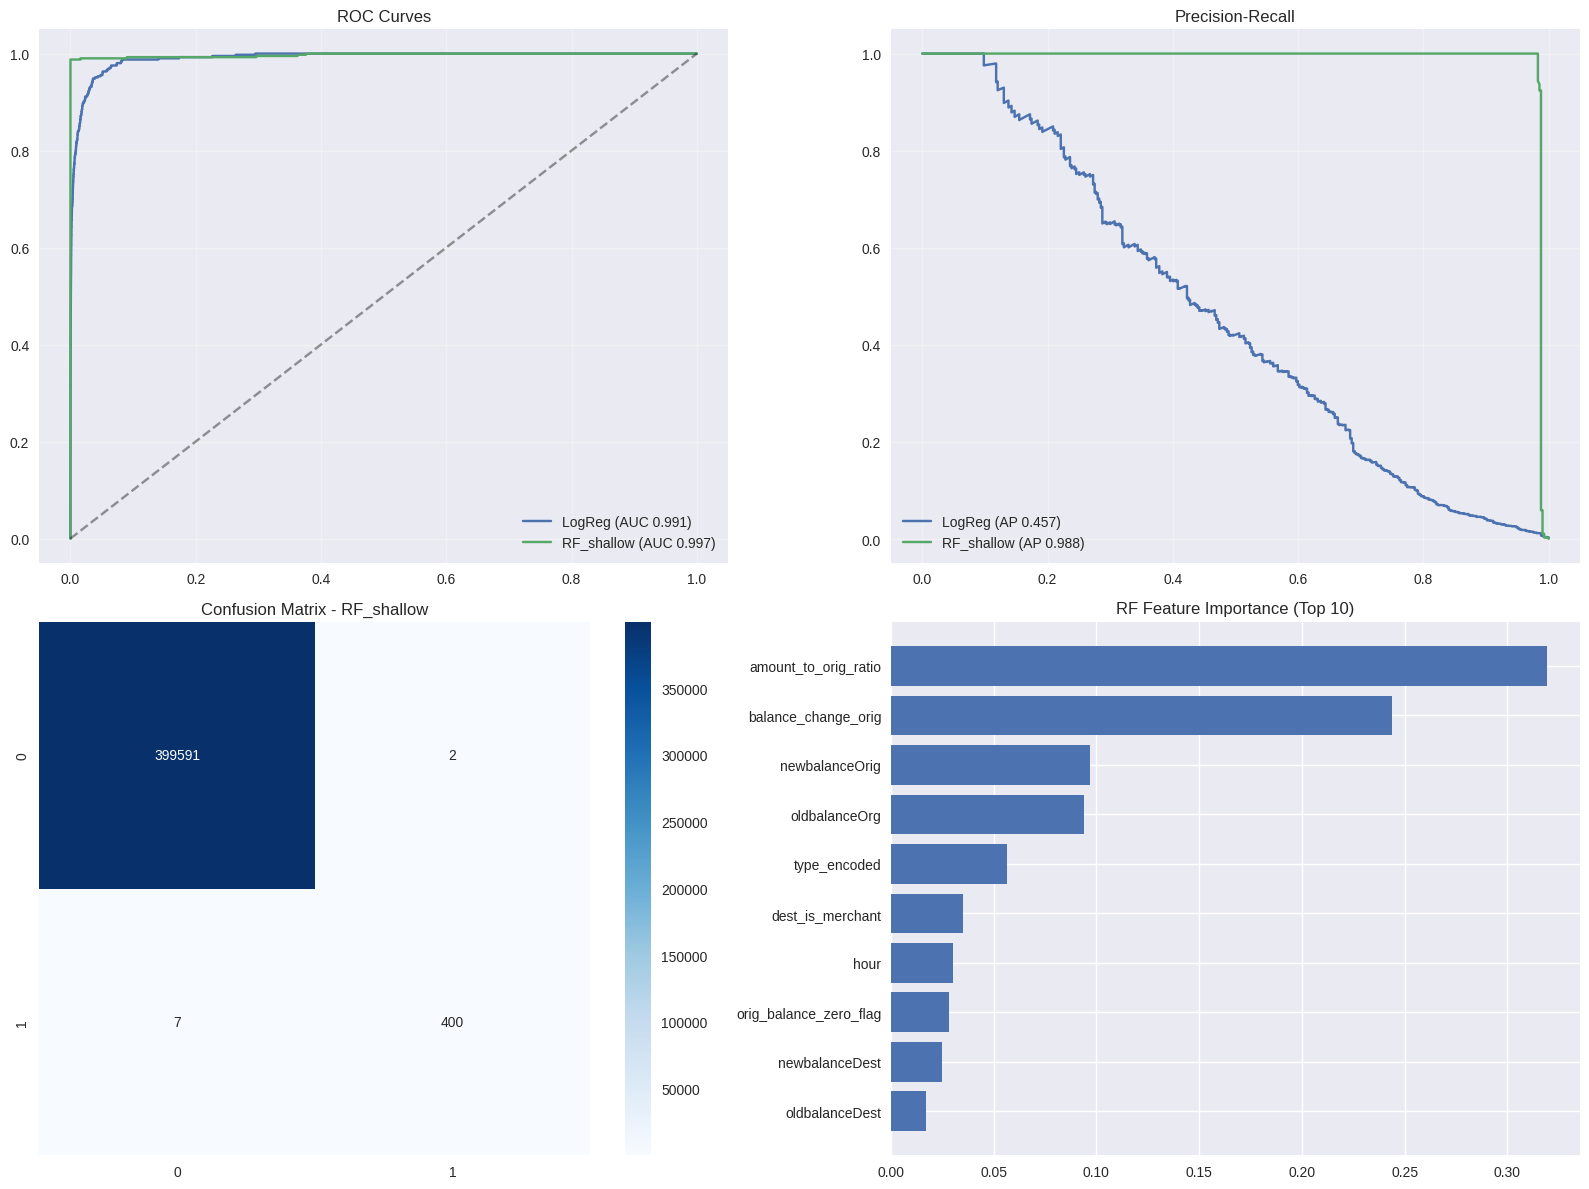

🏆 Best model: RF_shallow


In [ ]:
# Evaluation plots (on sampled test only) =====
def evaluate_models(results, X_test, y_test, selected_features):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    ax1, ax2, ax3, ax4 = axes.flat

    # ROC
    for name, res in results.items():
        fpr, tpr, _ = roc_curve(y_test, res['Prob'])
        ax1.plot(fpr, tpr, label=f"{name} (AUC {res['AUC']:.3f})")
    ax1.plot([0,1],[0,1],'k--', alpha=0.4)
    ax1.set_title('ROC Curves'); ax1.legend(); ax1.grid(True, alpha=0.3)

    # PR
    for name, res in results.items():
        prec, rec, _ = precision_recall_curve(y_test, res['Prob'])
        ax2.plot(rec, prec, label=f"{name} (AP {res['AP']:.3f})")
    ax2.set_title('Precision-Recall'); ax2.legend(); ax2.grid(True, alpha=0.3)

    # Confusion (best by AUC)
    best = max(results, key=lambda k: results[k]['AUC'])
    cm = confusion_matrix(y_test, results[best]['Pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
    ax3.set_title(f'Confusion Matrix - {best}')

    # RF feature importance if available
    if hasattr(results.get('RF_shallow', {}).get('Model', None), 'feature_importances_'):
        imp = results['RF_shallow']['Model'].feature_importances_
        tmp = pd.DataFrame({'feature': selected_features, 'importance': imp}).sort_values('importance').tail(10)
        ax4.barh(tmp['feature'], tmp['importance'])
        ax4.set_title('RF Feature Importance (Top 10)')

    plt.tight_layout()
    plt.show()
    return best

best_model = evaluate_models(results, X_test, y_test, selected_features)
print("Best model:", best_model)

## Results

Both models separate classes very well by ROC AUC, but Random Forest substantially outperforms Logistic Regression on Average Precision, which matters more under class imbalance. The Random Forest’s AUC=0.9972 and AP=0.9876 indicate near-perfect ranking and precision across recalls, while Logistic Regression’s AUC=0.9911 but lower AP=0.4566 suggests good ranking yet weaker precision-recall tradeoff for the rare fraud class.

## **Q/A as given in the task description**

---



1. **Data cleaning including missing values, outliers and multi-collinearity.**
- Filled numeric missings with zeros, capped outliers via IQR per chunk, and limited correlation heatmap to 15 numeric features.

2. **Describe your fraud detection model in elaboration.**
- Trained Logistic Regression (standardized, class-balanced) and a shallow Random Forest (regularized, class-balanced) on top-K mutual-information features.

3. **How did you select variables to be included in the model?**
- Computed mutual information on numeric predictors, ranked features, and kept the top 15, using float32 to reduce memory.

4. **Demonstrate the performance of the model by using best set of tools.**
- Evaluated with ROC/AUC and Precision-Recall/AP, confusion matrix for best model, and Random Forest feature importances visualization.

5. **What are the key factors that predict fraudulent customer?**
- Transaction type encoding, amount and log-amount, balance changes and zero-balance flags, temporal signals (hour, night), and amount ratios.

6. **Do these factors make sense? If yes, How? If not, How not?**
- Yes; fraud skews to certain types/times, abnormal amounts and inconsistent balances signal manipulation, consistent with transactional fraud behavior.

7. **What kind of prevention should be adopted while company update its infrastructure?**
- Enforce real-time checks on suspicious types/times/ratios, limits on zero-balance anomalies, and streaming model scoring with alerts.

8. **Assuming these actions have been implemented, how would you determine if they work?**
- Track post-deployment precision/recall, AP, fraud loss rate, alert volumes, and time-to-detect versus pre-deployment baselines over cohorts.

